# Vit Transformer

## Модель

In [1]:
#!pip install wandb -Uq

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.10 which is incompatible.


In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from IPython.display import clear_output
import wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Смоделируем данные

n_features = 10  # Количество признаков
n_classes = 3  # Количество классов
batch_size = 5 

data = torch.randn((batch_size, n_features))
print(data.shape)
print(data)

torch.Size([5, 10])

tensor([[ 1.2396, -0.3567, -0.5095,  0.4094,  1.1856, -2.5525, -0.0287,  0.7783,

          0.7127, -0.1368],

        [-1.4230,  1.2220,  0.1806, -0.0529,  0.7039,  1.6240,  0.2086, -0.8069,

         -0.6674,  1.4849],

        [-0.6212, -0.2427, -0.3448,  1.2180,  1.7626,  0.7934, -1.5433, -0.6886,

         -0.2446, -0.2879],

        [-1.8429, -1.4095, -0.9053, -0.2329, -0.7906,  1.0038,  1.9107,  0.0085,

          3.3173, -0.4781],

        [-1.6286, -2.0216, -2.2336,  0.9501,  1.8140,  0.9504,  0.3596,  0.0744,

         -1.8158,  0.8104]])


In [ ]:
# Зададим простую модель
model = nn.Linear(n_features, n_classes)

In [ ]:
# Применим модель к вектору
answer = model(data)
print(answer.shape)
print(answer)

torch.Size([5, 3])

tensor([[-0.0224,  0.3280, -0.8422],

        [ 0.3556, -0.3399, -0.1184],

        [ 0.2734, -0.5661, -0.4524],

        [ 2.1413, -0.4216,  1.0242],

        [ 0.2251, -0.4405,  0.4070]], grad_fn=<AddmmBackward0>)


In [ ]:
# Модель как наследник nn.Module
class SimpleNN(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()

        self.lin = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.lin(x)

In [ ]:
# Попробуем применить модель в виде класса к данным
model = SimpleNN(n_features, n_classes)

answer = model(data)
print(answer.shape)
print(answer)

torch.Size([5, 3])

tensor([[-0.6609,  0.8672,  0.6574],

        [ 0.1586, -0.6926, -0.3668],

        [ 0.5537, -1.1263, -1.0477],

        [ 0.5314, -0.4591, -0.1942],

        [ 0.5038, -1.3772, -1.0068]], grad_fn=<AddmmBackward0>)


In [ ]:
!pip install torchsummary
from torchsummary import summary

model = SimpleNN(n_features, n_classes).cuda()

# 5, 10
input_size = (batch_size, n_features)
print(summary(model, input_size))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Linear-1                 [-1, 5, 3]              33


Total params: 33

Trainable params: 33

Non-trainable params: 0

----------------------------------------------------------------

Input size (MB): 0.00

Forward/backward pass size (MB): 0.00

Params size (MB): 0.00

Estimated Total Size (MB): 0.00

----------------------------------------------------------------

None


In [ ]:
# Модель как sequential
model = nn.Sequential(nn.Linear(n_features, n_classes))

answer = model(data)
print(answer.shape)
print(answer)

torch.Size([5, 3])

tensor([[-0.0386, -0.0337, -0.4837],

        [-0.3787, -0.1409, -0.4653],

        [ 0.2811,  0.4510, -0.2073],

        [ 0.1829,  0.5183,  0.2787],

        [ 0.3269,  1.0411, -0.2115]], grad_fn=<AddmmBackward0>)


In [ ]:
# Модель как nn.ModuleList

model = nn.ModuleList([nn.Linear(n_features, n_classes)])

# answer = model(data)
# print(answer.shape)
# print(answer)

answer = model[0](data)
print(answer.shape)
print(answer)


torch.Size([5, 3])

tensor([[ 0.1790, -0.2065, -0.0337],

        [-0.2795,  0.1572,  0.1516],

        [-0.4237,  1.2880,  0.0912],

        [-0.0925,  0.7014,  0.2553],

        [ 0.6176,  1.1797, -0.7627]], grad_fn=<AddmmBackward0>)


In [ ]:
# Проверим параметры модели
class ParametersCheck(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()

        self.lin = nn.Linear(n_features, n_classes)
        self.seq = nn.Sequential(nn.Linear(n_features, n_classes))
        self.module_list = nn.ModuleList([nn.Linear(n_features, n_classes)])
        self.list_of_layers = [nn.Linear(n_features, n_classes)]
        self.parameter = nn.Parameter(data=torch.tensor([1.1]))


In [ ]:
model = ParametersCheck(n_features, n_classes)

for i, param in enumerate(model.parameters()):
    print(f'Параметр #{i + 1}.')
    print(f'\t{param.shape}')

Параметр #1.

	torch.Size([1])

Параметр #2.

	torch.Size([3, 10])

Параметр #3.

	torch.Size([3])

Параметр #4.

	torch.Size([3, 10])

Параметр #5.

	torch.Size([3])

Параметр #6.

	torch.Size([3, 10])

Параметр #7.

	torch.Size([3])


## ViT

![alt text](https://drive.google.com/uc?export=view&id=1J5TvycDPs8pzfvlXvtO5MCFBy64yp9Fa)

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.8 MB/s eta 0:00:00




In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

![](https://amaarora.github.io/images/vit-01.png)

## Часть 1. Patch Embedding, CLS Token, Position Encoding

![](https://amaarora.github.io/images/vit-02.png)

In [ ]:
# input image `B, C, H, W`
x = torch.randn(1, 3, 224, 224)
# 2D conv
conv = nn.Conv2d(3, 768, 16, 16)
conv(x).reshape(-1, 196).transpose(0,1).shape

torch.Size([196, 768])

In [25]:
class PatchEmbedding(nn.Module):
    """ 
    Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        self.patch_size = (patch_size,patch_size)
        self.img_size = (img_size,img_size)
        self.num_patches = (self.img_size[0] // patch_size) * (self.img_size[1] // patch_size)
        self.patch_embeddings = nn.Conv2d(in_chans, embed_dim, patch_size, patch_size)
        self.parameter = nn.Parameter(data=torch.tensor([1.1]))

    def forward(self, image):

        B, C, H, W = image.shape
        assert H == self.img_size[0] and W == self.img_size[1]
        patches = self.patch_embeddings(image).flatten(2).transpose(1,2)
        
        return patches

In [ ]:
patch_embed = PatchEmbedding()
x = torch.randn(1, 3, 224, 224)
patch_embed(x).shape 

torch.Size([1, 196, 768])

![](https://amaarora.github.io/images/vit-03.png)

## Часть 2. Transformer Encoder

![](https://amaarora.github.io/images/ViT.png)

![](https://amaarora.github.io/images/vit-07.png)

In [26]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()

        # Linear Layers
        self.lin1 = nn.Linear(in_features, hidden_features)
        self.lin2 = nn.Linear(hidden_features, out_features)

        # Activation(s)
        self.act = nn.GELU()

    def forward(self, x):
        
        x = self.lin1(x)
        x = self.act(x)
        x = self.lin2(x)
        #x = self.act(x)

        return x

Dropout на inference используется как некоторый множитель, который учитывает то, что на обучении модель обучалась не на всех весах.

In [ ]:
x = torch.randn(1, 197,768)
mlp = MLP(768, 3072, 768)
out = mlp(x)
out.shape

torch.Size([1, 197, 768])

In [27]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., out_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(in_features=dim, out_features=dim*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.out = nn.Linear(in_features=dim, out_features=dim)
        self.out_drop = nn.Dropout(out_drop)
        # attn = (q @ k.transpose(-2, -1)) * self.scale
        # attn = attn.softmax(dim=-1)

    def forward(self, x):
        B,C,DIMENTION = x.shape
        # Attention
        x = self.qkv(x)
        x = x.reshape(B, C, 3, self.num_heads, -1)
        def _unpack(y):
            for i in range(y.shape[2]):
                yield y[:,:,i,:].permute((0,2,1,3))
        q,k,v = _unpack(x)
        x = q @ k.transpose(-2,-1) / self.scale
        x = x.softmax(dim=-1)
        x = self.attn_drop(x)
        x = x @ v
        x = x.transpose(-3, -2)
        x = x.reshape(B,C, -1)

        # Out projection

        x = self.out(x)
        x = self.out_drop(x)

        return x


![](https://amaarora.github.io/images/vit-08.png)

In [ ]:
# attn = (q @ k.transpose(-2, -1)) * self.scale
# attn = attn.softmax(dim=-1)

In [ ]:
# x = torch.randn(2, 197, 2304)
# x = x.reshape(x.shape[0],x.shape[1],3,12, -1)
# print(x.shape)
# def unpack(y):
#     for i in range(y.shape[2]):
#         #print(y[:,:,i,:].permute((0,2,1,3)).shape)
#         yield y[:,:,i,:].permute((0,2,1,3))
# q,k,v = unpack(x)
# print(q.shape)
# attn = q @ k.transpose(-2,-1)
# attn = attn.softmax(dim=-1)
# attn = attn @ v
# attn.transpose(-3,-2).shape

torch.Size([2, 197, 3, 12, 64])

torch.Size([2, 12, 197, 64])


torch.Size([2, 197, 12, 64])

In [ ]:
# x = torch.randn(12,197,64)
# y = torch.randn(12,197,197)
# z = y @ x
# z = z.transpose(1,0)
# z = z.reshape(z.shape[0], -1)
# z.shape

In [ ]:
x = torch.randn(1, 197, 768)
attention = Attention(768, 8)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

In [28]:
class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()

        # Normalization
        layer_norm = nn.LayerNorm(dim)

        # Attention
        self.attention = Attention(dim, num_heads)

        # Dropout
        self.drop = nn.Dropout(drop_rate)

        # Normalization
        self.layer_norm = nn.LayerNorm(dim)

        # MLP
        self.mlp = MLP(in_features=dim, 
                       hidden_features=int(dim*mlp_ratio), 
                       out_features=dim)
                

    def forward(self, x):
        # Attetnion
        ln = self.layer_norm(x)
        attent = x + self.attention(ln)
        ln2 = self.layer_norm(attent)
        # MLP
        x = attent + self.mlp(ln2)
        return x

In [ ]:
x = torch.randn(1, 197, 768)
block = Block(768, 8)
out = block(x)
out.shape

torch.Size([1, 197, 768])

В оригинальной реализации теперь используется [DropPath](https://github.com/rwightman/pytorch-image-models/blob/e98c93264cde1657b188f974dc928b9d73303b18/timm/layers/drop.py)

In [29]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
x = torch.randn(1, 197, 768)
block = Transformer(12, 768)
out = block(x)
out.shape

torch.Size([1, 197, 768])

In [ ]:
# x = torch.randn(1,197,768)
# x = nn.Linear(768, 1000)(x)
# x = x.softmax(dim=1)
# x.

![](https://amaarora.github.io/images/vit-06.png)

In [30]:
from torch.nn.modules.normalization import LayerNorm

class ViT(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=528, patch_size=16, in_chans=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., 
                 qkv_bias=False, drop_rate=0.,):
        super().__init__()

        # Присвоение переменных
        ...

        # Path Embeddings, CLS Token, Position Encoding
        self.patch_embeddings = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )
        num_patches = self.patch_embeddings.num_patches
        self.cls_token = nn.Parameter(torch.randn([1,1,embed_dim]))
        self.pos_encoding = nn.Parameter(torch.randn(num_patches + 1, embed_dim))

        # Transformer Encoder
        self.transformer = Transformer(
            depth, 
            embed_dim, 
            num_heads, 
            mlp_ratio, 
            drop_rate
        )

        # Classifier
        self.classifier = MLP(in_features=embed_dim,hidden_features=int(embed_dim*mlp_ratio),out_features=num_classes)

    def forward(self, x):

        B = x.shape[0]
        x = self.patch_embeddings(x)
      
        # Path Embeddings, CLS Token, Position Encoding
        cls_tokens = self.cls_token.expand(B,-1,-1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding

        

        # Transformer Encoder
        x = self.transformer(x)

        # Classifier
        x = self.classifier(x[:,0,:])

        return x

In [ ]:
x = torch.randn(1, 3, 224, 224)
vit = ViT()
out = vit(x)
out.shape

AssertionError: 

# Домашнее задание


1. Выбрать датасет для классификации изображений с размерностью 64x64+ 
2. Обучить ViT на таком датасете.
3. Попробовать поменять размерности и посмотреть, что поменяется при обучении.


Примечание:
- Датасеты можно взять [тут](https://pytorch.org/vision/stable/datasets.html#built-in-datasets) или найти в другом месте.
- Из за того, что ViT учится медленно, количество примеров в датасете можно ограничить до 1к-5к.

CONFIG

In [8]:
TRAIN_DATA_DIR = '/kaggle/input/footballteams-classification/Train/GrayScaleTrain'
TEST_DATA_DIR = '/kaggle/input/footballteams-classification/Test/GrayScaleTest'

BATCH_SIZE = 8
NUM_EPOCHS = 45
NUM_CORES = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = '/kaggle/working/'

In [9]:
DEVICE

device(type='cuda', index=0)

In [10]:
sns.set(rc={'figure.figsize':(18,8)})

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


UTILS

In [12]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5] * 3) # [0.485, 0.456, 0.406]
    std = np.array([0.5] * 3) # [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
def show_grid(loader, dataset, classes=None, size=(4,4),):
    axes = plt.subplots(nrows=size[0], ncols=size[1], figsize=(12, 9))[1]
    t = next(iter(loader))
    if len(t) == 3:
        t = t[:-1]
    data, labels = t
    for ax, d, l in zip(axes.flatten(), data, labels):
        ax.axis("off")
        if classes:        
            imshow(d.data.cpu(), title=classes[l], plt_ax=ax)
        else:
            imshow(d.data.cpu(), plt_ax=ax)

In [15]:
# функция сохранения 
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [16]:
class ImageFolderWithPath(ImageFolder):
  '''
  Собственный класс ImageFolder.
  Вдобавок к тензеру и метке возвращает путь
  '''
  def __getitem__(self,index):
      original_tuple = super(ImageFolderWithPath,self).__getitem__(index)
      path = self.imgs[index][0]
      tuple_with_path = (original_tuple + (path,))
      return tuple_with_path

In [17]:
def split(data_dir, img_size, train_size=0.8, imagefolder=ImageFolder):
    
    RESCALE_SIZE = img_size
    augmentations = transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomHorizontalFlip(p=0.5),
    ])
    basic_transforms = transforms.Compose([
        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    ])
    train_transforms = transforms.Compose([
        augmentations,
        basic_transforms
    ])
    
    train_dataset = imagefolder(root=data_dir, transform=train_transforms)
    val_dataset = imagefolder(root=data_dir, transform=basic_transforms)
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(train_size * num_train))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[:split], indices[split:]

    traindata = Subset(train_dataset, indices=train_idx)
    valdata = Subset(val_dataset, indices=valid_idx)
    return traindata, valdata

In [18]:
def show_train_val_metric(losses, scores, epoch):
    clear_output(wait=True)

    axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))[1]
    axes[0].plot(range(len(losses['train'])), losses['train'],color='blue',label='train loss')
    axes[0].plot(range(len(losses['val'])), losses['val'],color='red',label='val loss')
    axes[0].set_title('Loss') 
    
    axes[1].plot(range(len(scores['train'])), scores['train'],color='blue',label='train f1')
    axes[1].plot(range(len(scores['val'])), scores['val'],color='red',label='val f1')
    axes[1].set_title('F1 macro')
    plt.legend()
    plt.suptitle('TRAIN: loss - %f, f1 macro - %f \n VAL: loss - %f, f1 macro - %f \n epoch - % d' % (losses['train'][-1], scores['train'][-1], losses['val'][-1], scores['val'][-1], epoch))


In [19]:
seed_everything()

In [24]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c footballteams-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists


100% 904M/906M [00:46<00:00, 25.9MB/s]

100% 906M/906M [00:46<00:00, 20.4MB/s]


In [25]:
# !mkdir images
# !unzip -q -o footballteams-classification.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

mkdir: cannot create directory ‘images’: File exists


In [20]:
temp = datasets.ImageFolder(root=TRAIN_DATA_DIR)
CLASSES = temp.classes
NUM_CLASSES = len(CLASSES)
NUM_CLASSES

10

In [22]:
count = np.unique(temp.targets, return_counts=True)
sample_per_class_count = dict(zip(*count))
sample_per_class_count

{0: 401,
 1: 325,
 2: 341,
 3: 339,
 4: 347,
 5: 320,
 6: 357,
 7: 337,
 8: 320,
 9: 311}

In [23]:
names_count = {CLASSES[k]:v for k,v in sample_per_class_count.items()}
names_count

{'Arsenal': 401,
 'Barcelona': 325,
 'Bayern': 341,
 'Chelsea': 339,
 'Juventus': 347,
 'Liverpool': 320,
 'ManchesterCity': 357,
 'ManchesterUnited': 337,
 'PSG': 320,
 'Real': 311}

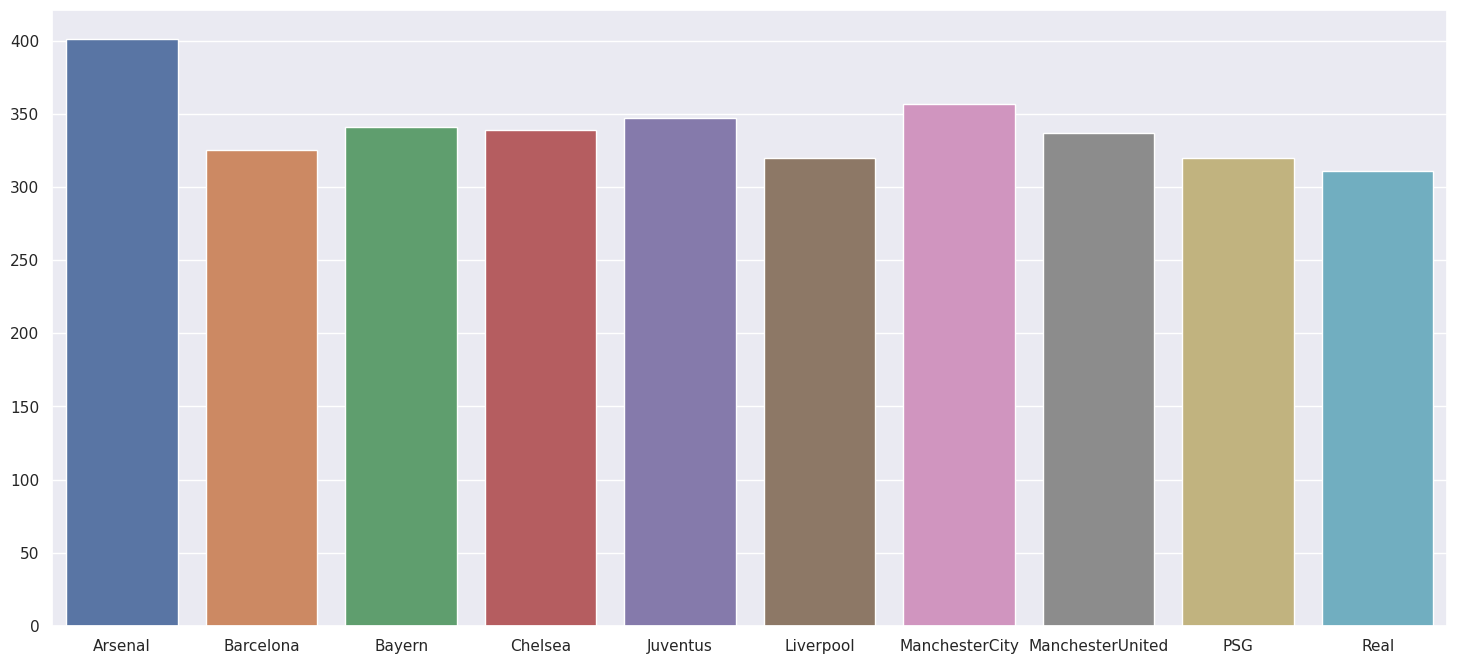

In [24]:
sns.barplot(x=list(names_count.keys()), y=list(names_count.values()));

In [24]:
train_dataset, val_dataset = split(TRAIN_DATA_DIR, img_size=224, imagefolder=ImageFolderWithPath)

In [ ]:
class_count = np.unique(train_dataset.dataset.targets, return_counts=True)
team_dict = dict(zip(*class_count))
class_weights = {k: 1/v for k, v in team_dict.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label, _) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = int(max(team_dict.values()) * len(team_dict))  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|██████████| 2718/2718 [01:32<00:00, 29.48it/s]


In [ ]:
len(train_dataset.dataset)

3398

In [27]:
loaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_CORES), #, sampler=train_sampler
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_CORES)
}

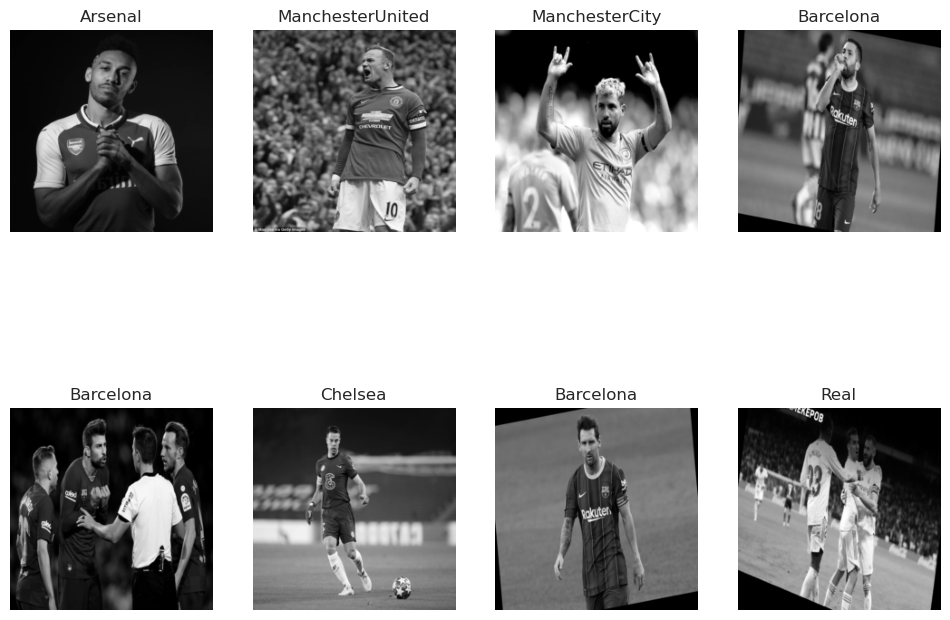

In [27]:
show_grid(loaders['train'], train_dataset, classes=CLASSES, size=(2,4))

In [ ]:
x = torch.randn(1,3,224,224).to(DEVICE)
out = model(x)
out.shape

torch.Size([1, 10])

In [1]:
model_path

NameError: name 'model_path' is not defined

In [31]:
import logging
def log_artifact(filename, model_path, metric_val, config):
    metadata = dict(config)
    metadata['f1_validation_score'] = metric_val
    artifact = wandb.Artifact(filename, type='model', metadata=metadata)
    artifact.add_file(model_path)
    logging.info('Saving checpoint =>')
    wandb.run.log_artifact(artifact)        

In [53]:
losses = {}
scores = {}
def train(model, criterion, optimizer, scheduler, loaders, epochs, config, model_name='ViT'):
    wandb.watch(model, criterion, log="all", log_freq=10)
    losses[model_name] = {'train': [], 'val':[]}
    scores[model_name] = {'train': [], 'val':[]}

    loop = tqdm(range(epochs))
    best_score = 0.0

    if loaders['val']:
        phases = ['train', 'val']
    else:
        phases = ['train']
        
    for epoch in loop:
        
        running_loss = 0.0
        running_score = 0.0
        
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            for inputs, labels, _ in tqdm(loaders[phase]):
                
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = outputs.argmax(dim=1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler:
                            scheduler.step()
                
                running_score += f1_score(labels.detach().cpu(), preds.detach().cpu(), average='macro')
                running_loss += loss.detach().cpu().item()

            running_score /= len(loaders[phase])
            running_loss /= len(loaders[phase])

            scores[model_name][phase].append(running_score)
            losses[model_name][phase].append(running_loss)
            
#             if scheduler and phase == 'train':
#                 scheduler.step()
            if phase == 'val' and running_score > best_score:
                best_score = running_score
                filename = f'H_{config.num_heads}_D_{config.depth}_IS_{config.img_size}_DR_{config.drop_rate}.pth'
                path = os.path.join(CHECKPOINT_PATH,filename)
                torch.save(model.state_dict(), path)
                log_artifact(filename, path, running_score, config)
            
            wandb.log({f'{phase} loss': running_loss, f'{phase} f1 macro': running_score})
        
        #show_train_val_metric(losses[model_name], scores[model_name], epoch=epoch)


In [ ]:
# model = ViT(num_classes=NUM_CLASSES, img_size=224).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3,cycle_momentum=False)
# criterion = torch.nn.CrossEntropyLoss()
# train(model, criterion, optimizer, scheduler, loaders, epochs=10)

In [56]:
sweep_config = {
    'method':'random',
    'parameters':
    {
        'learning_rate':{
            'value': 4e-4
        },
        'step_size':{
            'values':[5,7,10]
        },
        'num_heads': {
            'values': [8,12]
        },
        'depth':{
            'values':[8,12]
        },
        'img_size':{
            'values': [224]
        },
        'drop_rate': {
            'values': [0., 0.5]
        },
        'batch_size':{
            'value': 10
        },
        'epochs':{
            'value':30
        }
    }
}
sweep_id = wandb.sweep(sweep_config,project='ViT')

Create sweep with ID: qiokztnn
Sweep URL: https://wandb.ai/free4ky/ViT/sweeps/qiokztnn


In [57]:
def make(config):
    model = ViT(
        num_classes=NUM_CLASSES,
        img_size=config.img_size,
        num_heads=config.num_heads,
        depth=config.depth,
        drop_rate=config.drop_rate
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-7, max_lr=config.learning_rate,cycle_momentum=False, mode='triangular2')
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    train_dataset, val_dataset = split(TRAIN_DATA_DIR, img_size=config.img_size, imagefolder=ImageFolderWithPath)
    loaders = {
        'train': DataLoader(train_dataset, batch_size=config.batch_size, num_workers=NUM_CORES), #, sampler=train_sampler
        'val': DataLoader(val_dataset, batch_size=config.batch_size, num_workers=NUM_CORES)
    }
    
    return model, criterion, optimizer, scheduler, loaders
    
def model_pipeline(config=None):
    with wandb.init(project='ViT', config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        model, criterion, optimizer, scheduler, loaders = make(config)
        train(model, criterion, optimizer, scheduler, loaders, config.epochs, config)

In [ ]:
#train(NUM_EPOCHS, loaders, model_name='ViT')

In [ ]:
wandb.agent(sweep_id, model_pipeline, count=5)

wandb: Agent Starting Run: tn09fpqg with config:
wandb: 	batch_size: 10
wandb: 	depth: 12
wandb: 	drop_rate: 0.5
wandb: 	epochs: 30
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0004
wandb: 	num_heads: 12
wandb: 	step_size: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

train f1 macro,▁▄▅▄▄▄▄▄▄▅▅▆▆▇▇██▇▆▅▄▄▄▄▃▄▄▅▅▆
train loss,█▅▄▄▄▄▄▄▃▃▃▃▃▂▁▁▁▂▃▃▄▄▄▄▄▄▄▃▃▂
val f1 macro,▁▁▃▃▄▄▄▅▆▅▅▃▅▇█▇▅▄▆▃▃▂▄▁▃▁▃▄▄▃
val loss,▆█▆▅▄▃▆▄▃▃▃▃▄▁▁▂▃▃▂▄▄▄▄▇▄▆▆▄▃▃
train f1 macro,0.16194
train loss,1.93991
val f1 macro,0.14588
val loss,2.02743


wandb: Agent Starting Run: x2jrhra8 with config:
wandb: 	batch_size: 10
wandb: 	depth: 8
wandb: 	drop_rate: 0
wandb: 	epochs: 30
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0004
wandb: 	num_heads: 8
wandb: 	step_size: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

К сожалению, добиться хорошего результата на обучении не удалось, возможно я ошибся в архитектуре модели, но не могу найти ошибку.
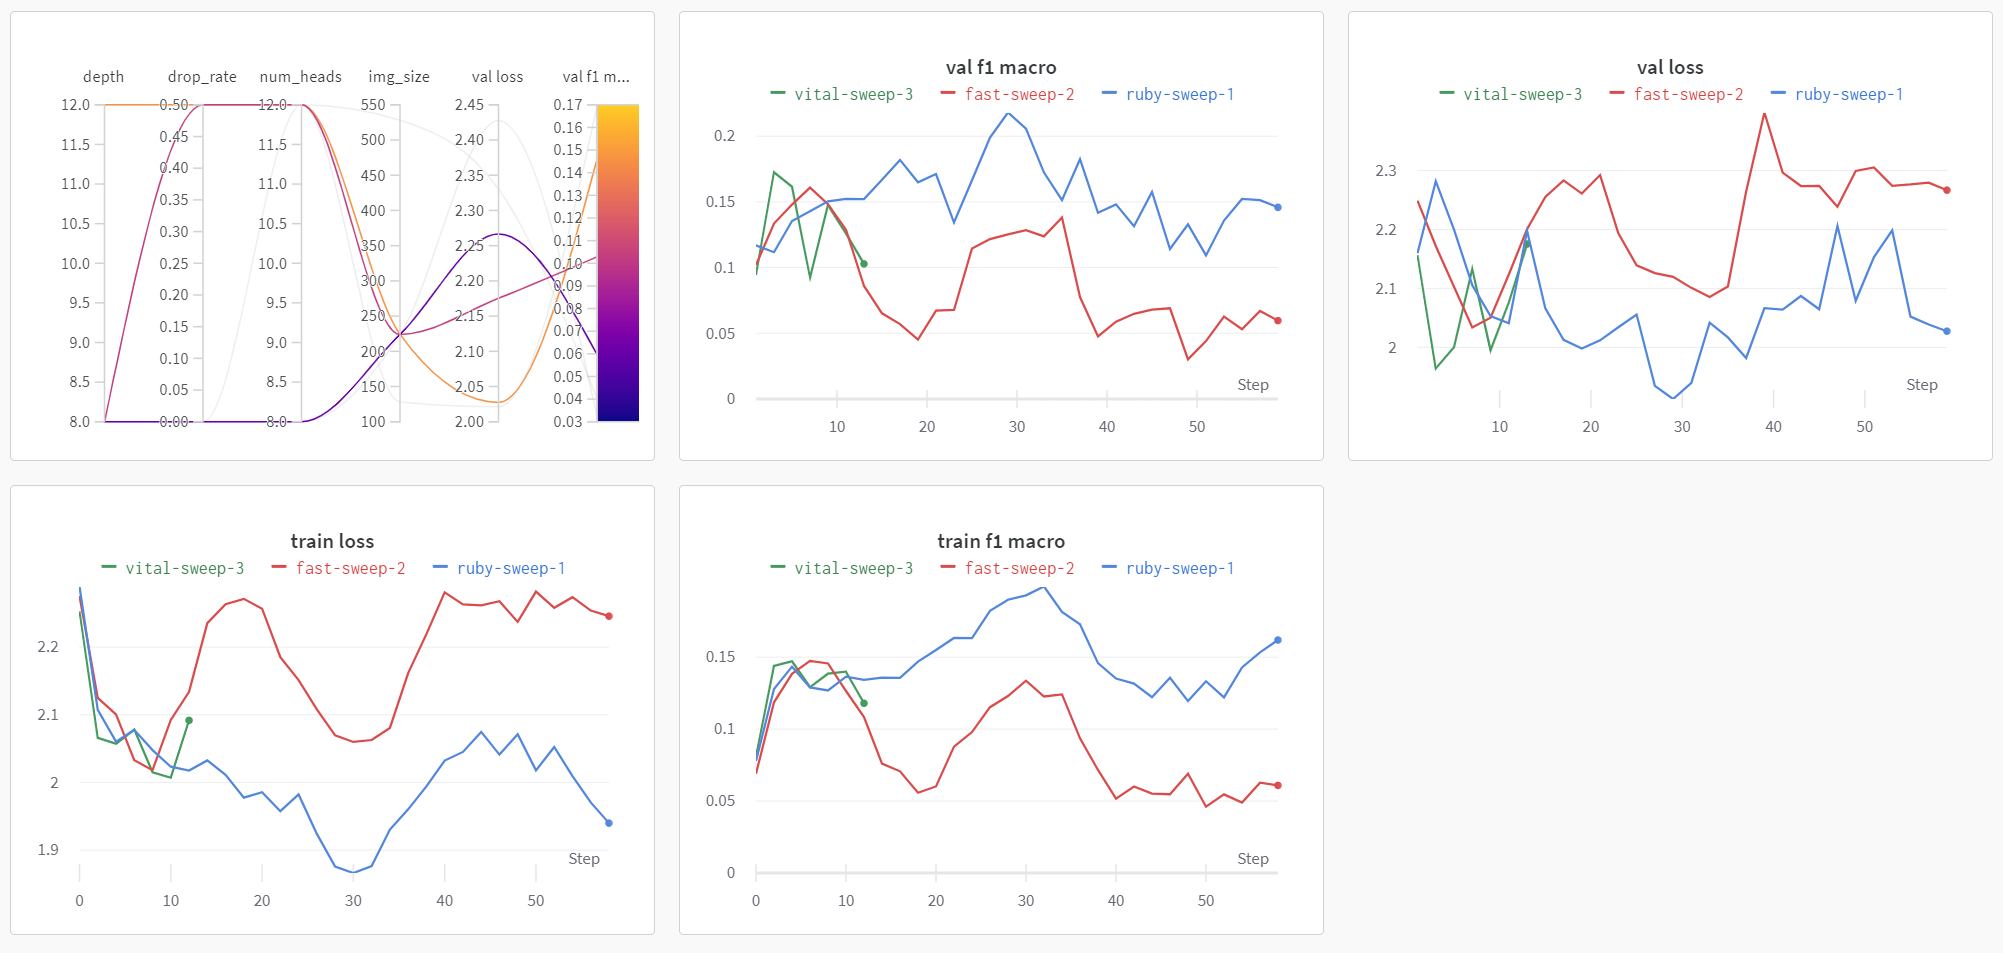